In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def InitialCondition_Delta(r,r0,Sigma0):
    dr=r[1]-r[0]
    Sigma=np.zeros(r.size)
    delta= np.where(np.fabs(r-r0)<=dr)[0]
    
    Sigma[delta]=Sigma0* (1.0 - np.fabs(r-r0)[delta]/dr) 
    return Sigma

def InitialCondition_PowerLaw(r,r0,Sigma0,exp):
    
    return Sigma0*np.power(r/r0,exp)

In [3]:
def BoundaryCondition_InnerCopy(r,Sigma):
    Sigma[0]=Sigma[1]
    
def BoundaryCondition_OuterCopy(r,Sigma):
    Sigma[nr-1]=Sigma[nr-2]
    

def BoundaryCondition_Inner(r,Sigma,boundary):
    Sigma[0]=boundary
    
def BoundaryCondition_Outer(r,Sigma,boundary):
    Sigma[-1]=boundary    

In [4]:
def CFL_Condition_Diff(dr,Diffusion):
    if Diffusion>0:
        Courant_Diff= 0.3*dr*dr/Diffusion
        return Courant_Diff
    else:
        return np.infty

In [5]:
def Compute_Diffusion(r,Sigma,visc):
    #Following equation 5.8 in the diffusion form
    '''
    #This does NOT work!
    dr=r[1]-r[0]
    Diff=3.0*visc    
    dq=np.zeros_like(q)    
    dq[1:nr-1]= Diff*(q[2:nr] - 2.0*q[1:nr-1] + q[0:nr-2])/(dr*dr)
    '''
    
    #This Works
    s=2.0*np.sqrt(r)
    q=np.multiply(Sigma,s)
    
    dq_dr2=np.zeros_like(q)
    dq_dr2[1:nr-1]= np.divide(q[2:nr]-q[1:nr-1],s[2:nr]-s[1:nr-1]) - np.divide(q[1:nr-1]-q[0:nr-2],s[1:nr-1]-s[0:nr-2])
    dq_dr2[1:nr-1]= 2.0*np.divide(dq_dr2[1:nr-1],s[2:nr]-s[0:nr-2])
    
    dSigma_dt=12.0*visc*np.divide(dq_dr2,np.power(s,3.0))
    
    return dSigma_dt
    

In [6]:
Mstar=1.0           #Solar Mass
r0=1.0              #AU
visc=0.001          #Weird Units
m_disk=0.01*Mstar   #Disk mass

t_orbit=2.0*np.pi
t_visc=r0*r0/(12.0*visc)

nr=500
r_min=0.01
r_max=2.0

dr=(r_max-r_min)/nr
r=np.linspace(r_min+0.5*dr,r_max-0.5*dr,num=nr,endpoint=True)

t_start=0.0*t_visc
t_end=0.512*t_visc
dt=0.001*t_visc


t_output=0.002*t_visc


Sigma0=m_disk/(2.0*np.pi*r0*dr)
Sigma=InitialCondition_Delta(r,r0,Sigma0)+0.0001*Sigma0
#Sigma=InitialCondition_PowerLaw(r,r0,Sigma0,-1.5)

floor_Sigma=np.amin(Sigma)

In [7]:
t=t_start
t_save=t_output

Output_Dens=[]
Output_Dens.append(np.copy(Sigma))

while t<t_end:
    
    #Find the timestep using Courant Condition
    dt_0=np.amin([dt,t_output-t, CFL_Condition_Diff(dr,3.0*visc)])
    
    #Evolve the Density through Diffusion
    dSigma_dt=Compute_Diffusion(r,Sigma,visc)
    Sigma+=dSigma_dt*dt_0
    
    #Apply Boundary Conditions
    #Notice that the cells 0 and nr-1 are treated as ghost cells and never touched except by the boundary conditions
    #BoundaryCondition_BothSides(r,Sigma,0.0)
    BoundaryCondition_InnerCopy(r,Sigma)
    BoundaryCondition_Outer(r,Sigma,floor_Sigma)
    
    
    
    #Check if it is time to save
    t+=dt_0
    if t_output-t<=0.0:
        t_output=t_output*4.0
        Output_Dens.append(np.copy(Sigma))
    #Update the Time


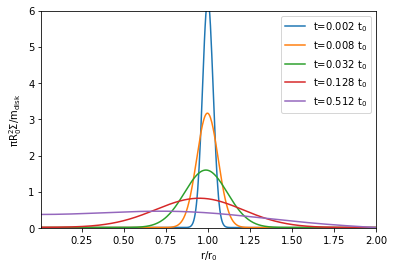

In [8]:
plt.xlabel("$\mathdefault{r/r_0}$")
plt.ylabel("$\mathdefault{\pi R_0^2\Sigma/m_{disk}}$")
plt.xlim([r_min,r_max])
plt.ylim([0.0,6.0])

#plt.plot(r/r0, Analytic_Density(r,0.00000001*t_output,r0,Sigma0,visc)/Sigma0,"r--",label="t="+str(np.around(t_output*s/t_orbit,decimals=1))+" $\mathdefault{t_0}$" )
    
for s in range(1,len(Output_Dens)):
    plt.plot(r/r0, np.pi*r0*r0*Output_Dens[s]/m_disk,label="t="+str(2.0**(2.0*s-1.0)/1000.0)+" $\mathdefault{t_0}$" )
    plt.legend()